# Top 7% TITANIC notebook

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Importing libraries

In [2]:
import pandas as pd
import numpy as np
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Getting the data

We will assign the data to **data_train** and **data_test** data frames and check the amount of data and number of features.

In [3]:
data_train = pd.read_csv('../input/titanic/train.csv') 
data_test = pd.read_csv('../input/titanic/test.csv')

print(" Data training: "+str(data_train.shape[0]) + " rows and " + str(data_train.shape[1] - 1) + " features" + "\n",
      "Data test: "+str(data_test.shape[0]) + " rows and " + str(data_test.shape[1]) + " features")

 Data training: 891 rows and 11 features
 Data test: 418 rows and 11 features


# Take a brief look at the data

Let's check the data format and what we have in columns.

In [4]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


As you can see, we have a lot of features of Titanic's passengers. 
We need to check these features and make an analysis to know what is the most important features and if we can build new features from those already been in our data.

# Defining input and output for training

Let's create two data frames, the first has the features and the second has the labels.

In [6]:
X_train = data_train.drop(['Survived'],axis=1)
y_train = data_train[['Survived']]

Let's check our data. Note that it is important to check each step because we have a lot of steps and one mistake will be passed forward to the next steps. 

**Hint: one way to avoid a lot of checks is using pipelines. Unfortunately, I didn't use it but can be
useful. You can learn about pipelines in Kaggle micro-courses.**

In [7]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We have 11 features. **PassengerId** is just a number to identify the passengers, but you don't need to worry about it. **P-class** is the ticket class, the numbers are 1, 2, or 3, low values are more expensive. People in 1st class, for example, have better accommodations than 3rd class tickets. The **Name** has the passenger's names, pay attention to the title that a person has in your name (Mr, Miss, Mrs, Mr). **Sex** is about male or female. **Age** is the passenger's age. **SibSp** is a number of siblings/spouses aboard the Titanic. **Parch** is the number of parents/children aboard the Titanic. In **Ticket**, we have these names, but we don't know about the ticket's name meaning. **Fare** is the money that the passenger needs to pay to trip in titanic. The **Cabin** is the cabin's number and **Embarked** is the port of embarkation.

In [8]:
y_train.head()

,Survived
0,0
1,1
2,1
3,1
4,0


# Analysing data

Let's check the data using the **describe** method from pandas.

In [9]:
data_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


You need to note that categorical data won't be shown above (name, ticket, sex...). Next steps we will deal with categorical data, now let's take a look at the numerical data above. We can see that all the features, except Age, are without blanks (remember we have 891 rows in data_train). This is good because we didn't lose a lot of data. Note that, however, we can fill the NaN values with median, median, or another process, never this will be better than have the original data.

Looking above we can check that max Age is 80, Fare values have a large interval between min and max. It's important to take a look at the **describe method** of a data frame, so you can get more insights about the data. 

In [10]:
data_train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


Fare and Pclass have the absolute highest correlation. After that, we have Parch and SibSp, and Fare and Survived. Note that Pclass and Survived are not continuous data, so these correlations aren't interesting for us. Correlation is more useful when we are making regression instead of classification.

## Analysing features

### Analysing 'sex' feature

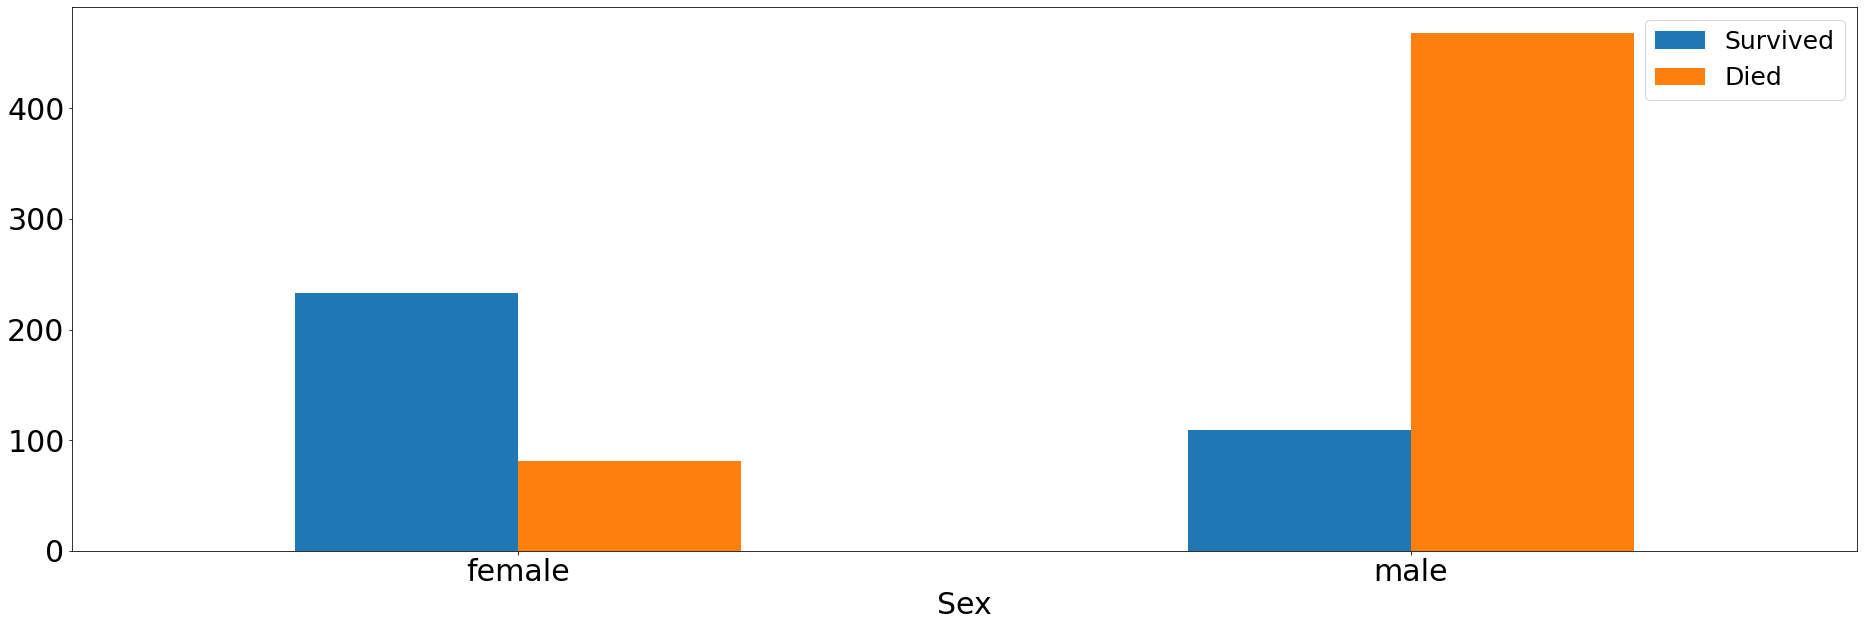

In [11]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import pylab as plot

params = { 
    'axes.labelsize': 30,
    'legend.fontsize': 25
}

plot.rcParams.update(params)

data_train['Died'] = 1 - data_train['Survived']
data_train.groupby('Sex').agg('sum')[['Survived', 'Died']].plot(kind='bar', figsize=(32, 10),rot=0, fontsize = 30)

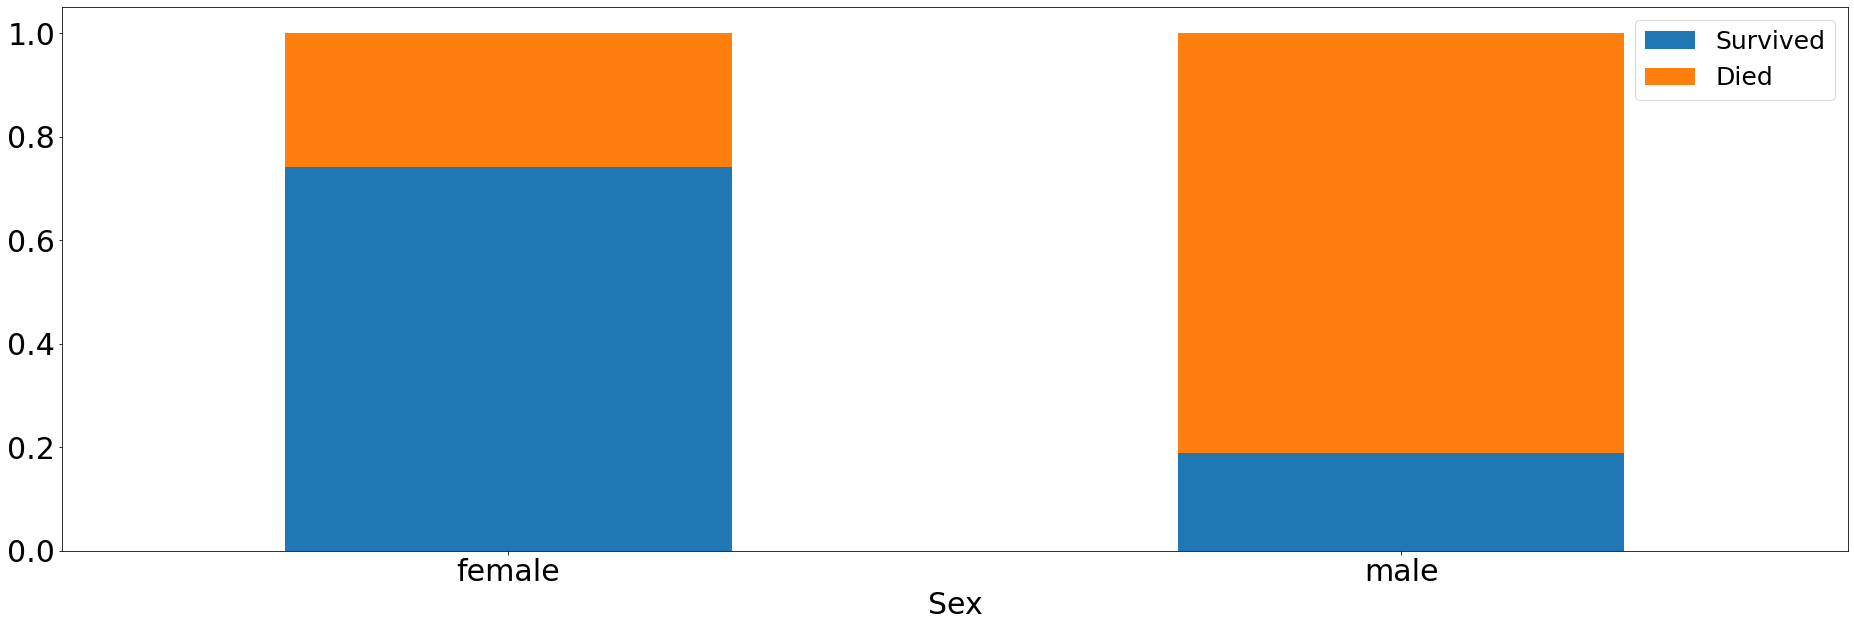

In [12]:

data_train.groupby('Sex').agg('mean')[['Survived', 'Died']].plot(kind='bar', figsize=(32, 10),stacked=True,rot=0, fontsize = 30)

Clearly we can see that 'sex' has a huge importance at survival of titanic's people. In this case, female has more chances to survive.

### Age vs Survived

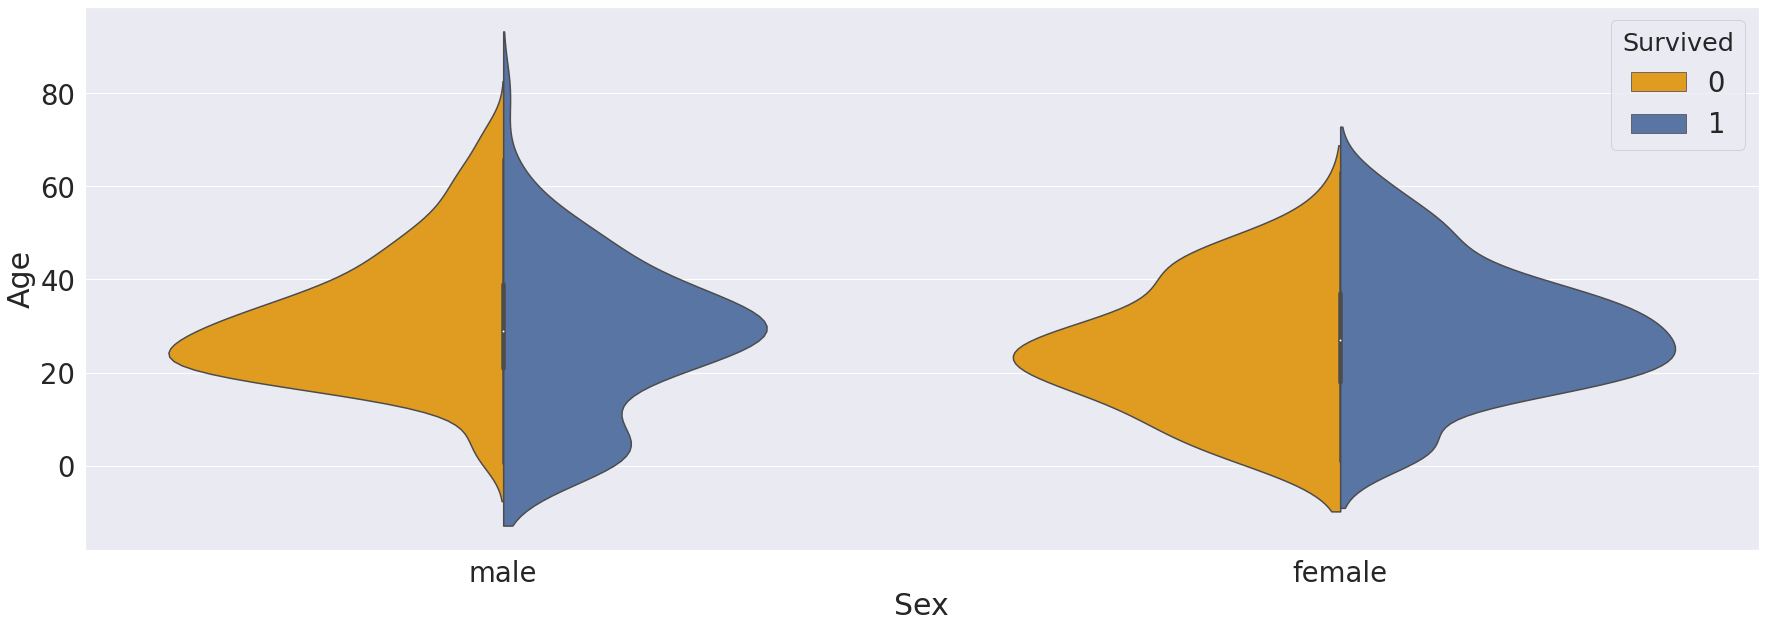

In [13]:
fig = plt.figure(figsize=(30, 10))
sns.set(font_scale = 2.5)
sns.violinplot(x='Sex', y='Age', 
               hue='Survived', data=data_train, 
               split=True,
               palette={0: "orange", 1: "b"}
              );

As we can see, young people had more chance to survive. If you look at blue, there are local peaks in both, male and female. However, when we look at the orange, the local peak is at old females. The global peak for males and females is about 20 yrs old.

### Number of passengers

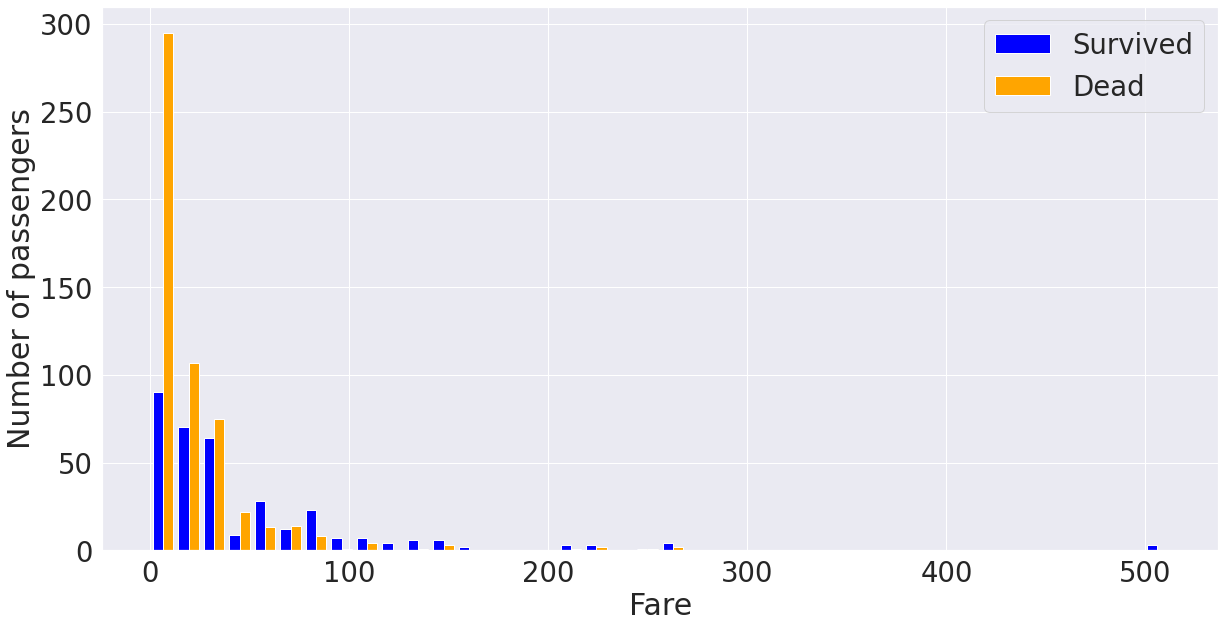

In [14]:
figure = plt.figure(figsize=(20, 10))

plt.hist([data_train[data_train['Survived'] == 1]['Fare'], data_train[data_train['Survived'] == 0]['Fare']], 
         stacked=False, color = ['blue','orange'],
         bins = 40, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend();

When we look at the histogram above, we can see that most poor people died. It's, once you are poor, you will have more chance to die. Looking at the richest people, the number of deaths decreased a lot, once you are rich, you will be less chance to die. For example, we can see that fare > 100 people has more chance to be alive than dead.

### Classes

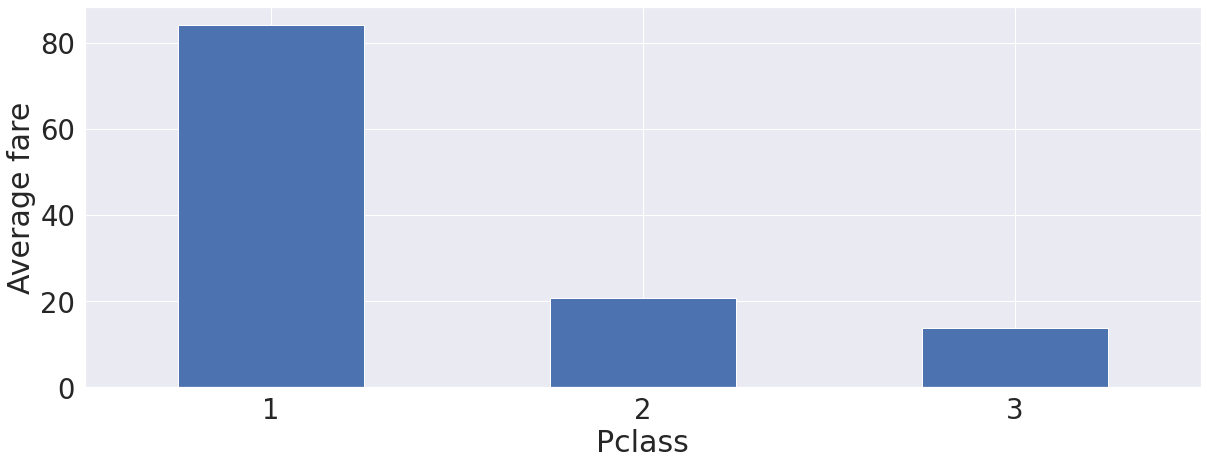

In [15]:
ax = plt.subplot()
ax.set_ylabel('Average fare')
data_train.groupby('Pclass').mean()['Fare'].plot(kind='bar', figsize=(20, 7), ax = ax, rot = 0);

Above, we can see that people in class 1 is significantly richer than the other classes. Class 3 is the poorest. So, we see that class 1 people had more chances to be alive.

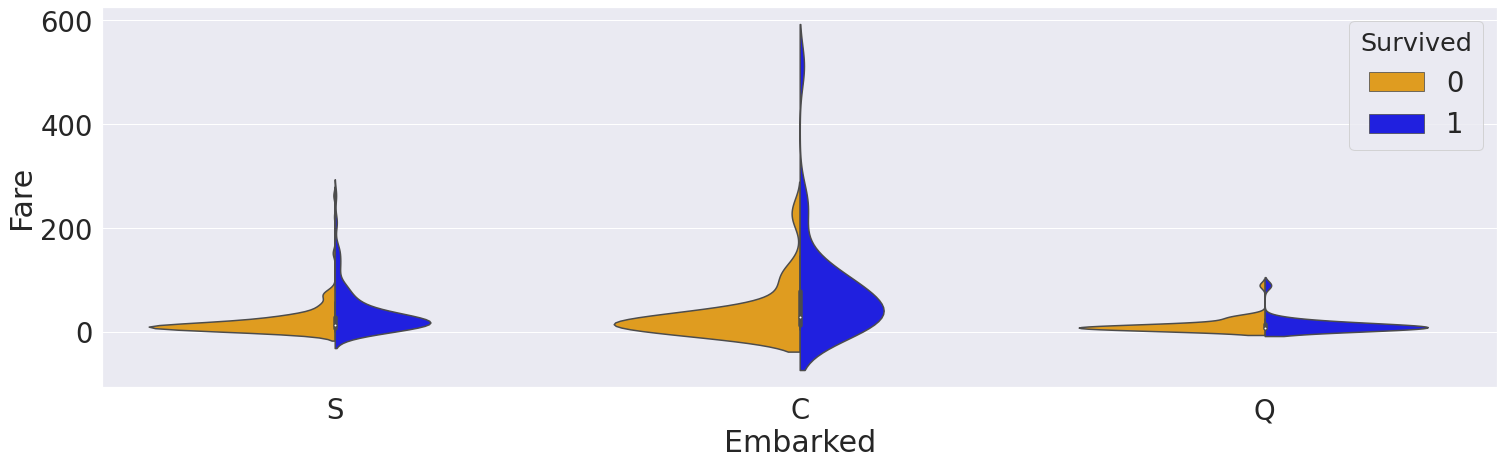

In [16]:
fig = plt.figure(figsize=(25, 7))
sns.violinplot(x='Embarked', y='Fare', hue='Survived', data=data_train, split=True, palette={0: "orange", 1: "blue"});


Now we are looking at port embarked, fare, and survival. Again, we see that richer people have more chances to be alive, except at embarked Q. Q embarked seems to be symmetrical, so poor and rich people have approximately the same chance to be alive.

# -- Feature Engineering --

# Creating column "Title"

Once we know that rich people have more chances to be alive, your title is important to survive. Create a column with titles can be an interesting feature. After creating this and other features, we're gonna create a random forest model and we will check feature importance using the **feature_importances_** method.

In [17]:
titles = set()
for name in data_train['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

print("data_train",titles, '\n')

titles = set()
for name in data_test['Name']:
    titles.add(name.split(',')[1].split('.')[0].strip())

print("data_test",titles, '\n')

data_train {'Rev', 'Miss', 'Major', 'Don', 'Mr', 'Dr', 'Col', 'Sir', 'the Countess', 'Jonkheer', 'Ms', 'Mme', 'Lady', 'Mrs', 'Master', 'Capt', 'Mlle'} 

data_test {'Rev', 'Miss', 'Mr', 'Col', 'Dr', 'Ms', 'Mrs', 'Master', 'Dona'} 



In [18]:
Title_Dictionary = {
    "Capt": "Officer",
    "Col": "Officer",
    "Major": "Officer",
    "Jonkheer": "Royalty",
    "Don": "Royalty",
    "Sir" : "Royalty",
    "Dr": "Officer",
    "Rev": "Officer",
    "the Countess":"Royalty",
    "Mme": "Mrs",
    "Mlle": "Miss",
    "Ms": "Mrs",
    "Mr" : "Mr",
    "Mrs" : "Mrs",
    "Miss" : "Miss",
    "Master" : "Master",
    "Lady" : "Royalty",
    "Dona" : "Mrs"
}

def status(feature):
    print('Processing', feature, ': ok')

def get_titles(combined):
    # we extract the title from each name
    combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    
    # a map of more aggregated title
    # we map each title
    combined['Title'] = combined.Title.map(Title_Dictionary)
    status('Title')
    return combined

In [19]:
X_train = get_titles(X_train)

Processing Title : ok


In [20]:
X_train

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Officer
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss
888,889,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S,Miss
889,890,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr


In [21]:
data_test = get_titles(data_test)

Processing Title : ok


In [22]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs


In [23]:
data_test[data_test['Title'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


# Missing fare values

I note that some values in Fare are equal to zero, so I decided to create a data frame with median values in the same sex, class, and title group. I took these values and replace them where our data frame was zero.

In [24]:
grouped_train = X_train.groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Fare']]

grouped_median_train

,Sex,Pclass,Title,Fare
0,female,1,Miss,88.25000
1,female,1,Mrs,79.20000
2,female,1,Officer,25.92920
3,female,1,Royalty,63.05000
4,female,2,Miss,13.00000
5,female,2,Mrs,26.00000
6,female,3,Miss,8.75625
7,female,3,Mrs,15.97500
8,male,1,Master,120.00000
9,male,1,Mr,42.40000


In [25]:
X_train[X_train["Fare"]==0]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
179,180,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,Mr
263,264,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,Mr
271,272,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,Mr
277,278,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,Mr
302,303,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,Mr
413,414,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,NaN,S,Mr
466,467,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,NaN,S,Mr
481,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,NaN,S,Mr
597,598,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,Mr
633,634,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,NaN,S,Mr


In [26]:
X_train[X_train["PassengerId"]==278]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
277,278,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,NaN,S,Mr


In [27]:
def fill_fare(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Fare'].values[0]


def process_fare(combined):
    # a function that fills the missing values of the Age variable
    combined['Fare'] = combined.apply(lambda row: fill_fare(row) if row['Fare'] == 0 else row['Fare'], axis=1)
    combined.Fare.fillna(combined.Fare.mean(), inplace=True)
    return combined

X_train = process_fare(X_train)

data_test = process_fare(data_test)

In [28]:
X_train[X_train["PassengerId"]==278]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
277,278,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,13.0,NaN,S,Mr


In [29]:
X_train[X_train["Fare"]==0]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


In [30]:
data_test[data_test["Fare"]==0]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title


# Missing age values

I made the same at ages values that we didn't have in our dataframe.

In [31]:
grouped_train = X_train.groupby(['Sex','Pclass','Title'])
grouped_median_train = grouped_train.median()
grouped_median_train = grouped_median_train.reset_index()[['Sex', 'Pclass', 'Title', 'Age']]

grouped_median_train

,Sex,Pclass,Title,Age
0,female,1,Miss,30.0
1,female,1,Mrs,40.0
2,female,1,Officer,49.0
3,female,1,Royalty,40.5
4,female,2,Miss,24.0
5,female,2,Mrs,31.5
6,female,3,Miss,18.0
7,female,3,Mrs,31.0
8,male,1,Master,4.0
9,male,1,Mr,40.0


In [32]:
def fill_age(row):
    condition = (
        (grouped_median_train['Sex'] == row['Sex']) & 
        (grouped_median_train['Title'] == row['Title']) & 
        (grouped_median_train['Pclass'] == row['Pclass'])
    ) 
    return grouped_median_train[condition]['Age'].values[0]


def process_age(combined):
    # a function that fills the missing values of the Age variable
    combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
    status('age')
    return combined

X_train = process_age(X_train)
data_test = process_age(data_test)

Processing age : ok
Processing age : ok


In [33]:
data_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,Mr
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,Mrs
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,Mr
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,Mr
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,Mrs
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,26.0,0,0,A.5. 3236,8.0500,NaN,S,Mr
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,Mrs
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,Mr
416,1308,3,"Ware, Mr. Frederick",male,26.0,0,0,359309,8.0500,NaN,S,Mr


# One-Hot Encoding - Title

In [34]:
def process_names(combined):
    # we clean the Name variable
    combined.drop('Name', axis=1, inplace=True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(combined['Title'], prefix='Title')
    combined = pd.concat([combined, titles_dummies], axis=1)
    
    # removing the title variable
    combined.drop('Title', axis=1, inplace=True)
    
    status('names')
    return combined

X_train = process_names(X_train)
data_test = process_names(data_test)

Processing names : ok
Processing names : ok


# One-Hot Encoding - Embarked

In [35]:
def process_embarked(combined):
    # two missing embarked values - filling them with the most frequent one in the train  set(S)
    combined.Embarked.fillna('S', inplace=True)
    # dummy encoding 
    embarked_dummies = pd.get_dummies(combined['Embarked'], prefix='Embarked')
    combined = pd.concat([combined, embarked_dummies], axis=1)
    combined.drop('Embarked', axis=1, inplace=True)
    status('embarked')
    return combined


In [36]:
X_train = process_embarked(X_train)
data_test = process_embarked(data_test)

Processing embarked : ok
Processing embarked : ok


# Remove PassengerId

In [37]:
X_train.drop('PassengerId', axis=1, inplace=True)
data_test.drop('PassengerId', axis=1, inplace=True)

# One-Hot Encoding - Cabin

In [38]:
train_cabin, test_cabin = set(), set()

for c in X_train['Cabin']:
    try:
        train_cabin.add(c[0])
    except:
        train_cabin.add('U')

print(train_cabin)
# set(['A', 'C', 'B', 'E', 'D', 'G', 'F', 'U', 'T'])

{'A', 'B', 'T', 'G', 'D', 'E', 'C', 'U', 'F'}


In [39]:
def process_cabin(combined):    
    # replacing missing cabins with U (for Uknown)
    combined.Cabin.fillna('U', inplace=True)
    
    # mapping each Cabin value with the cabin letter
    combined['Cabin'] = combined['Cabin'].map(lambda c: c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(combined['Cabin'], prefix='Cabin')    
    combined = pd.concat([combined, cabin_dummies], axis=1)

    combined.drop('Cabin', axis=1, inplace=True)
    status('cabin')
    return combined

In [40]:
X_train = process_cabin(X_train)
data_test = process_cabin(data_test)

Processing cabin : ok
Processing cabin : ok


# Categorical value - Sex

In [41]:
def process_sex(combined):
    # mapping string values to numerical one 
    combined['Sex'] = combined['Sex'].map({'male':1, 'female':0})
    status('Sex')
    return combined

X_train = process_sex(X_train)
data_test = process_sex(data_test)

Processing Sex : ok
Processing Sex : ok


In [42]:
X_train.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,...,Embarked_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,3,1,22.0,1,0,A/5 21171,7.2500,0,0,1,...,1,0,0,0,0,0,0,0,0,1
1,1,0,38.0,1,0,PC 17599,71.2833,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,3,0,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,...,1,0,0,0,0,0,0,0,0,1
3,1,0,35.0,1,0,113803,53.1000,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,3,1,35.0,0,0,373450,8.0500,0,0,1,...,1,0,0,0,0,0,0,0,0,1


# One-Hot Encoding - Pclass

In [43]:
def process_pclass(combined):
    # encoding into 3 categories:
    pclass_dummies = pd.get_dummies(combined['Pclass'], prefix="Pclass")
    
    # adding dummy variable
    combined = pd.concat([combined, pclass_dummies],axis=1)
    
    # removing "Pclass"
    combined.drop('Pclass',axis=1,inplace=True)
    
    status('Pclass')
    return combined

X_train = process_pclass(X_train)
data_test = process_pclass(data_test)

Processing Pclass : ok
Processing Pclass : ok


In [44]:
X_train.head()

,Sex,Age,SibSp,Parch,Ticket,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Pclass_1,Pclass_2,Pclass_3
0,1,22.0,1,0,A/5 21171,7.2500,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,0,38.0,1,0,PC 17599,71.2833,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
2,0,26.0,0,0,STON/O2. 3101282,7.9250,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,0,35.0,1,0,113803,53.1000,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4,1,35.0,0,0,373450,8.0500,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1


# One-hot enconding - ticket

In [45]:
def cleanTicket(ticket):
    ticket = ticket.replace('.', '')
    ticket = ticket.replace('/', '')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip(), ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'

def process_ticket(combined):
    
    # a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
    def cleanTicket(ticket):
        ticket = ticket.replace('.','')
        ticket = ticket.replace('/','')
        ticket = ticket.split()
        ticket = map(lambda t : t.strip(), ticket)
        #ticket = filter(lambda t : not t.isdigit(), ticket)
        ticket = [t for t in ticket if not t.isdigit()]
        if len(ticket) > 0:
            return ticket[0]
        else: 
            return 'XXX'
    

    # Extracting dummy variables from tickets:

    combined['Ticket'] = combined['Ticket'].map(cleanTicket)
    tickets_dummies = pd.get_dummies(combined['Ticket'], prefix='Ticket')
    combined = pd.concat([combined, tickets_dummies], axis=1)
    combined.drop('Ticket', inplace=True, axis=1)

    status('Ticket')
    return combined

X_train = process_ticket(X_train)
data_test = process_ticket(data_test)

Processing Ticket : ok
Processing Ticket : ok


In [46]:
X_train.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,1,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


# Add feature - family

In [47]:
def process_family(combined):
    
    # introducing a new feature : the size of families (including the passenger)
    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    
    # introducing other features based on the family size
    combined['Singleton'] = combined['FamilySize'].map(lambda s: 1 if s == 1 else 0)
    combined['SmallFamily'] = combined['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
    combined['LargeFamily'] = combined['FamilySize'].map(lambda s: 1 if 5 <= s else 0)
    
    status('family')
    return combined

In [48]:
process_family(X_train)
process_family(data_test)

Processing family : ok
Processing family : ok


,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_STONO,Ticket_STONO2,Ticket_STONOQ,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,34.5,0,0,7.8292,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0
1,0,47.0,1,0,7.0000,0,0,0,1,0,...,0,0,0,0,0,1,2,0,1,0
2,1,62.0,0,0,9.6875,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0
3,1,27.0,0,0,8.6625,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0
4,0,22.0,1,1,12.2875,0,0,0,1,0,...,0,0,0,0,0,1,3,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1,26.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
414,0,39.0,0,0,108.9000,0,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
415,1,38.5,0,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0
416,1,26.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0


In [49]:
X_train.head()

,Sex,Age,SibSp,Parch,Fare,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,...,Ticket_STONO,Ticket_STONO2,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX,FamilySize,Singleton,SmallFamily,LargeFamily
0,1,22.0,1,0,7.2500,0,0,1,0,0,...,0,0,0,0,0,0,2,0,1,0
1,0,38.0,1,0,71.2833,0,0,0,1,0,...,0,0,0,0,0,0,2,0,1,0
2,0,26.0,0,0,7.9250,0,1,0,0,0,...,0,1,0,0,0,0,1,1,0,0
3,0,35.0,1,0,53.1000,0,0,0,1,0,...,0,0,0,0,0,1,2,0,1,0
4,1,35.0,0,0,8.0500,0,0,1,0,0,...,0,0,0,0,0,1,1,1,0,0


# Chosing features

In [50]:
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [51]:
clf = RandomForestClassifier(random_state=0)
clf = clf.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


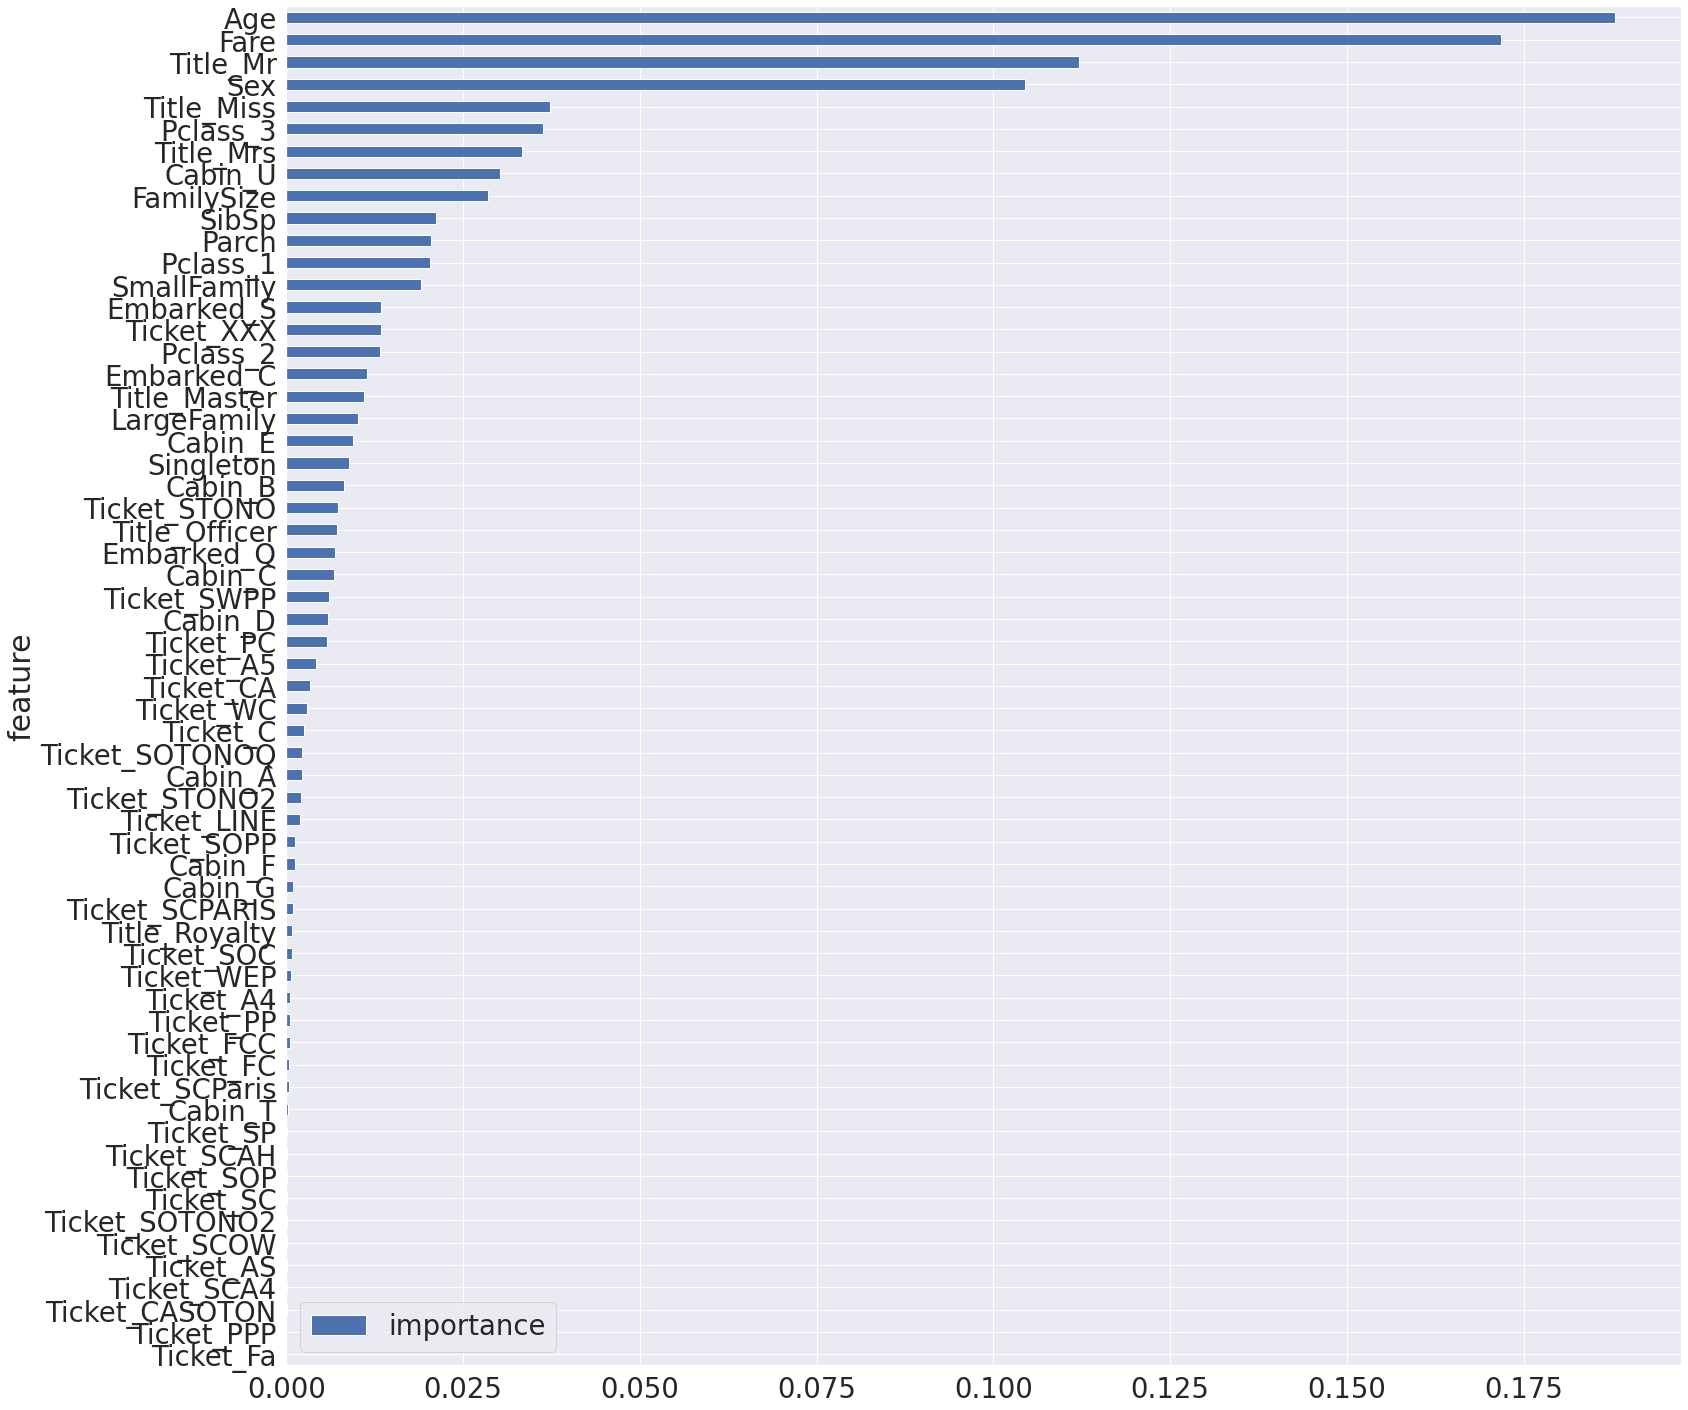

In [52]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))

In [53]:
features['importance'].sort_values(ascending=True)

features.index

Index(['Ticket_Fa', 'Ticket_PPP', 'Ticket_CASOTON', 'Ticket_SCA4', 'Ticket_AS',
       'Ticket_SCOW', 'Ticket_SOTONO2', 'Ticket_SC', 'Ticket_SOP',
       'Ticket_SCAH', 'Ticket_SP', 'Cabin_T', 'Ticket_SCParis', 'Ticket_FC',
       'Ticket_FCC', 'Ticket_PP', 'Ticket_A4', 'Ticket_WEP', 'Ticket_SOC',
       'Title_Royalty', 'Ticket_SCPARIS', 'Cabin_G', 'Cabin_F', 'Ticket_SOPP',
       'Ticket_LINE', 'Ticket_STONO2', 'Cabin_A', 'Ticket_SOTONOQ', 'Ticket_C',
       'Ticket_WC', 'Ticket_CA', 'Ticket_A5', 'Ticket_PC', 'Cabin_D',
       'Ticket_SWPP', 'Cabin_C', 'Embarked_Q', 'Title_Officer', 'Ticket_STONO',
       'Cabin_B', 'Singleton', 'Cabin_E', 'LargeFamily', 'Title_Master',
       'Embarked_C', 'Pclass_2', 'Ticket_XXX', 'Embarked_S', 'SmallFamily',
       'Pclass_1', 'Parch', 'SibSp', 'FamilySize', 'Cabin_U', 'Title_Mrs',
       'Pclass_3', 'Title_Miss', 'Sex', 'Title_Mr', 'Fare', 'Age'],
      dtype='object', name='feature')

# Data training

In [54]:
#X_train = X_train[['LargeFamily','FamilySize','Fare','Cabin_U','Title_Officer','Age','Pclass_3','Title_Mr']]
X_train = X_train[['Cabin_G', 'Ticket_FCC',
       'Ticket_STONO2', 'Ticket_SCPARIS', 'Cabin_F',
       'Ticket_CA', 'Ticket_WC', 'Ticket_SOTONOQ', 'Cabin_A',
       'Ticket_A5', 'Title_Officer', 'Ticket_STONO',
       'Title_Master', 'Cabin_D', 'Ticket_PC', 'Singleton', 'Cabin_C',
       'Cabin_B', 'Embarked_Q', 'Cabin_E', 'Embarked_C', 'LargeFamily',
       'Pclass_2', 'Ticket_XXX', 'Parch', 'Embarked_S', 'Pclass_1',
       'SmallFamily', 'SibSp', 'FamilySize', 'Title_Mrs', 'Title_Miss',
       'Cabin_U', 'Pclass_3', 'Sex', 'Title_Mr', 'Age', 'Fare']]


In [55]:
X_train.head()

,Cabin_G,Ticket_FCC,Ticket_STONO2,Ticket_SCPARIS,Cabin_F,Ticket_CA,Ticket_WC,Ticket_SOTONOQ,Cabin_A,Ticket_A5,...,SibSp,FamilySize,Title_Mrs,Title_Miss,Cabin_U,Pclass_3,Sex,Title_Mr,Age,Fare
0,0,0,0,0,0,0,0,0,0,1,...,1,2,0,0,1,1,1,1,22.0,7.2500
1,0,0,0,0,0,0,0,0,0,0,...,1,2,1,0,0,0,0,0,38.0,71.2833
2,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1,1,1,0,0,26.0,7.9250
3,0,0,0,0,0,0,0,0,0,0,...,1,2,1,0,0,0,0,0,35.0,53.1000
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,35.0,8.0500


# Data test

In [56]:
#data_test = data_test[['LargeFamily','FamilySize','Fare','Cabin_U','Title_Officer','Age','Pclass_3','Title_Mr']]

data_test = data_test[['Cabin_G', 'Ticket_FCC',
       'Ticket_STONO2', 'Ticket_SCPARIS', 'Cabin_F',
       'Ticket_CA', 'Ticket_WC', 'Ticket_SOTONOQ', 'Cabin_A',
       'Ticket_A5', 'Title_Officer', 'Ticket_STONO',
       'Title_Master', 'Cabin_D', 'Ticket_PC', 'Singleton', 'Cabin_C',
       'Cabin_B', 'Embarked_Q', 'Cabin_E', 'Embarked_C', 'LargeFamily',
       'Pclass_2', 'Ticket_XXX', 'Parch', 'Embarked_S', 'Pclass_1',
       'SmallFamily', 'SibSp', 'FamilySize', 'Title_Mrs', 'Title_Miss',
       'Cabin_U', 'Pclass_3', 'Sex', 'Title_Mr', 'Age', 'Fare']]


In [57]:
data_test.head()

,Cabin_G,Ticket_FCC,Ticket_STONO2,Ticket_SCPARIS,Cabin_F,Ticket_CA,Ticket_WC,Ticket_SOTONOQ,Cabin_A,Ticket_A5,...,SibSp,FamilySize,Title_Mrs,Title_Miss,Cabin_U,Pclass_3,Sex,Title_Mr,Age,Fare
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,34.5,7.8292
1,0,0,0,0,0,0,0,0,0,0,...,1,2,1,0,1,1,0,0,47.0,7.0000
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,1,62.0,9.6875
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,1,27.0,8.6625
4,0,0,0,0,0,0,0,0,0,0,...,1,3,1,0,1,1,0,0,22.0,12.2875


# Parameter tuning

In [58]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 

param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300]
}
# Create a based model
rf = RandomForestClassifier(random_state=0)
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 10, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   32.1s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  3.5min finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 200}

In [59]:
#X_train
# 100, 3 , 3, 12, 200
model = RandomForestClassifier(bootstrap= True,
 max_depth = 90,
 max_features = 3,
 min_samples_leaf = 3,
 min_samples_split = 12,
 n_estimators = 200,random_state=0)

In [60]:
model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestClassifier(max_depth=90, max_features=3, min_samples_leaf=3,
                       min_samples_split=12, n_estimators=200, random_state=0)

In [61]:
features['importance'].sort_values(ascending=True)

features.index

Index(['Ticket_Fa', 'Ticket_PPP', 'Ticket_CASOTON', 'Ticket_SCA4', 'Ticket_AS',
       'Ticket_SCOW', 'Ticket_SOTONO2', 'Ticket_SC', 'Ticket_SOP',
       'Ticket_SCAH', 'Ticket_SP', 'Cabin_T', 'Ticket_SCParis', 'Ticket_FC',
       'Ticket_FCC', 'Ticket_PP', 'Ticket_A4', 'Ticket_WEP', 'Ticket_SOC',
       'Title_Royalty', 'Ticket_SCPARIS', 'Cabin_G', 'Cabin_F', 'Ticket_SOPP',
       'Ticket_LINE', 'Ticket_STONO2', 'Cabin_A', 'Ticket_SOTONOQ', 'Ticket_C',
       'Ticket_WC', 'Ticket_CA', 'Ticket_A5', 'Ticket_PC', 'Cabin_D',
       'Ticket_SWPP', 'Cabin_C', 'Embarked_Q', 'Title_Officer', 'Ticket_STONO',
       'Cabin_B', 'Singleton', 'Cabin_E', 'LargeFamily', 'Title_Master',
       'Embarked_C', 'Pclass_2', 'Ticket_XXX', 'Embarked_S', 'SmallFamily',
       'Pclass_1', 'Parch', 'SibSp', 'FamilySize', 'Cabin_U', 'Title_Mrs',
       'Pclass_3', 'Title_Miss', 'Sex', 'Title_Mr', 'Fare', 'Age'],
      dtype='object', name='feature')

# Creating submission

In [62]:
model.predict(data_test)

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,

In [63]:
output = model.predict(data_test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('../input/titanic/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('gridsearch_rf_rn_stt_03_01.csv', index=False)

# References

How To Start with Kaggle — An Introduction to the Titanic 🚢 Challenge: https://medium.com/datadriveninvestor/start-with-kaggle-a-comprehensive-guide-to-solve-the-titanic-challenge-8ac5815b0473

Matplotlib tutorial: https://matplotlib.org/3.3.3/tutorials/introductory/customizing.html

Pandas plot: https://pandas.pydata.org/pandas-docs/version/0.15.2/generated/pandas.DataFrame.plot.html

Scikit learn (grid_search): https://scikit-learn.org/stable/modules/grid_search.html

GridSearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html